In [2]:
!pip install torchdiffeq
!pip install torchsde
!pip install ipdb
!pip install torchcfm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
# from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15016486.70it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 536340.38it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4623966.78it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9510997.89it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
#################################
#    Class Conditional CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
# Users can try target FM by changing the above line by
# FM = TargetConditionalFlowMatcher(sigma=sigma)
# node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [9]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}")

epoch: 0, steps: 0, loss: 0.1565
epoch: 0, steps: 1, loss: 0.151
epoch: 0, steps: 2, loss: 0.1565
epoch: 0, steps: 3, loss: 0.1526
epoch: 0, steps: 4, loss: 0.1479
epoch: 0, steps: 5, loss: 0.1658
epoch: 0, steps: 6, loss: 0.1599
epoch: 0, steps: 7, loss: 0.1662
epoch: 0, steps: 8, loss: 0.1606
epoch: 0, steps: 9, loss: 0.1693
epoch: 0, steps: 10, loss: 0.1626
epoch: 0, steps: 11, loss: 0.1541
epoch: 0, steps: 12, loss: 0.1612
epoch: 0, steps: 13, loss: 0.1549
epoch: 0, steps: 14, loss: 0.1691
epoch: 0, steps: 15, loss: 0.1683
epoch: 0, steps: 16, loss: 0.1581
epoch: 0, steps: 17, loss: 0.1548
epoch: 0, steps: 18, loss: 0.17
epoch: 0, steps: 19, loss: 0.1489
epoch: 0, steps: 20, loss: 0.167
epoch: 0, steps: 21, loss: 0.1631
epoch: 0, steps: 22, loss: 0.1442
epoch: 0, steps: 23, loss: 0.162
epoch: 0, steps: 24, loss: 0.1422
epoch: 0, steps: 25, loss: 0.1607
epoch: 0, steps: 26, loss: 0.1549
epoch: 0, steps: 27, loss: 0.1729
epoch: 0, steps: 28, loss: 0.1671
epoch: 0, steps: 29, loss: 0.

In [10]:
data = next(iter(train_loader))

In [12]:
data[0].shape, data[1].shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [13]:
x1, y = data
x1 , y = x1.to(device), y.to(device)
x0 = torch.randn_like(x1)
t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

In [21]:
xt.shape, ut.shape, t.shape, y.shape

(torch.Size([128, 1, 28, 28]),
 torch.Size([128, 1, 28, 28]),
 torch.Size([128]),
 torch.Size([128]))

In [22]:
from ipdb import set_trace as st

In [41]:
# x(t+Δt)=x(t)+Δt⋅f(t,x(t))
def sample(model, nsteps = 100):
  st()

  ts = torch.linspace(0, 1, nsteps)
  x0 = torch.randn(10, 1, 28, 28).to(device)
  ys = torch.arange(0, 10, 1).to(device)

  xt = x0
  with torch.no_grad():

    for index in range(1, ts.shape[0]):

      delta_t = ts[index] - ts[index - 1]
      t = torch.tensor([ts[index]]*x0.shape[0]).to(device)
      vt = model(t, xt, ys)
      xt += delta_t * vt

  return xt

In [43]:
x1 = sample(model)

> <ipython-input-41-f3cfb88d5ab2>(5)sample()
      4 
----> 5   ts = torch.linspace(0, 1, nsteps)
      6   x0 = torch.randn(10, 1, 28, 28).to(device)

ipdb> c


In [55]:
ToPILImage()(x1[9])

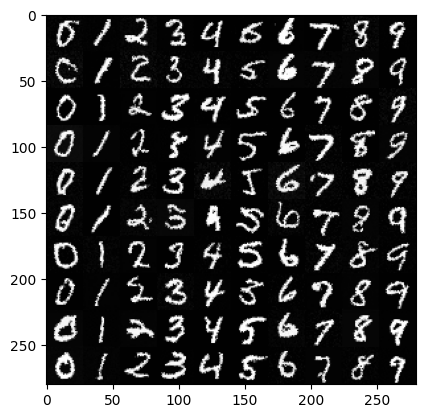

In [37]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [ ]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut, _, y1 = FM.guided_sample_location_and_conditional_flow(x0, x1, y1=y)
        vt = model(t, xt, y1)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

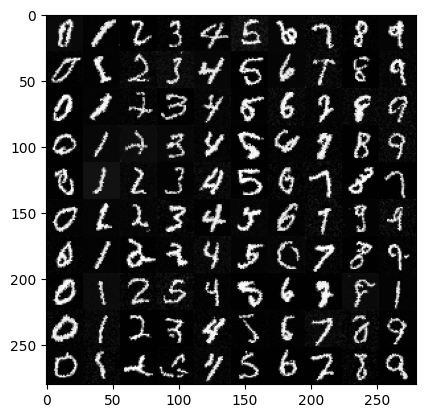

In [ ]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
#################################
#            SF2M
#################################
batch_size = 128
n_epochs = 10
sigma = 0.1


model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
score_model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

optimizer = torch.optim.Adam(list(model.parameters()) + list(score_model.parameters()))
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [ ]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut, _, y1, eps = FM.guided_sample_location_and_conditional_flow(
            x0, x1, y1=y, return_noise=True
        )
        lambda_t = FM.compute_lambda(t)
        vt = model(t, xt, y1)
        st = score_model(t, xt, y1)
        flow_loss = torch.mean((vt - ut) ** 2)
        score_loss = torch.mean((lambda_t[:, None, None, None] * st + eps) ** 2)
        loss = flow_loss + score_loss
        loss.backward()
        optimizer.step()

468it [01:27,  5.38it/s]
468it [01:27,  5.36it/s]
468it [01:27,  5.36it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.36it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]


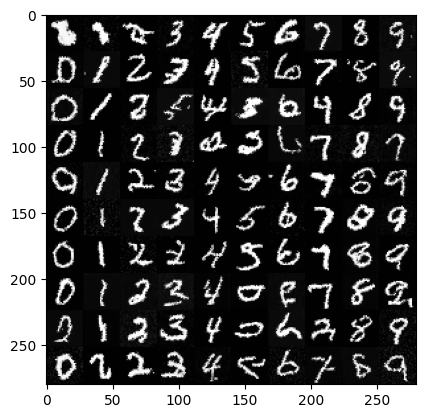

In [ ]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)

node = NeuralODE(model, solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
# Evaluate the ODE
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

In [ ]:
# follows example from https://github.com/google-research/torchsde/blob/master/examples/cont_ddpm.py


class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, labels=None, reverse=False, sigma=0.1):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.reverse = reverse
        self.labels = labels
        self.sigma = sigma

    # Drift

    def f(self, t, y):
        y = y.view(-1, 1, 28, 28)
        if self.reverse:
            t = 1 - t
            return -self.drift(t, y, self.labels) + self.score(t, y, self.labels)
        return self.drift(t, y, self.labels).flatten(start_dim=1) + self.score(
            t, y, self.labels
        ).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y) * self.sigma

In [ ]:
sde = SDE(model, score_model, labels=torch.arange(10, device=device).repeat(10), sigma=0.1)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        # x0.view(x0.size(0), -1),
        torch.randn(100, 1 * 28 * 28, device=device),
        ts=torch.linspace(0, 1, 2, device=device),
        dt=0.01,
    )

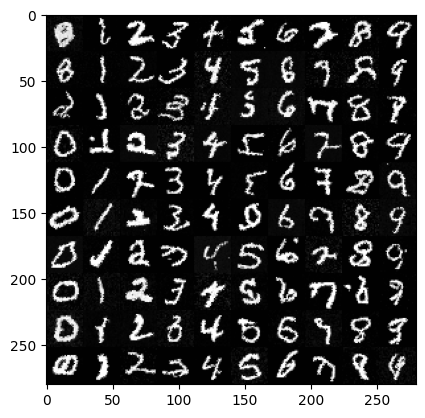

In [ ]:
grid = make_grid(
    sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)